In [103]:
import pandas as pd
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
import re
import tensorflow as tf

In [104]:
parquet_file = [
    'data/train-00000-of-00004-b4aaeceff1d90ecb.parquet',
    'data/train-00001-of-00004-7dbbe248962764c5.parquet',
    'data/train-00002-of-00004-688fe1305a55e5cc.parquet',
    'data/train-00003-of-00004-2d0cd200555ed7fd.parquet',
    'data/validation-00000-of-00001-cc3c5779fe22e8ca.parquet',
    # 'data/test-00000-of-00001-9c204eb3f4e11791.parquet',
    ]

df = pd.concat([pd.read_parquet(f) for f in parquet_file])

In [105]:
df.head()

,image,ground_truth
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Nasi Campur Bal..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""SPGTHY BOLOGNAS..."
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""HAKAU UDANG"", ""..."
3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": [{""nm"": ""Bintang Bremer""..."
4,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"{""gt_parse"": {""menu"": {""nm"": ""BASO BIHUN"", ""un..."


In [106]:
json.loads(df['ground_truth'].iloc[4])['valid_line']

[{'words': [{'quad': {'x2': 172,
     'y3': 836,
     'x3': 172,
     'y4': 836,
     'x1': 96,
     'y1': 800,
     'x4': 96,
     'y2': 800},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BASO'},
   {'quad': {'x2': 272,
     'y3': 834,
     'x3': 272,
     'y4': 834,
     'x1': 180,
     'y1': 798,
     'x4': 180,
     'y2': 798},
    'is_key': 0,
    'row_id': 2119099,
    'text': 'BIHUN'}],
  'category': 'menu.nm',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 444,
     'y3': 830,
     'x3': 444,
     'y4': 830,
     'x1': 424,
     'y1': 796,
     'x4': 424,
     'y2': 796},
    'is_key': 0,
    'row_id': 2119099,
    'text': '1'}],
  'category': 'menu.cnt',
  'group_id': 3,
  'sub_group_id': 0},
 {'words': [{'quad': {'x2': 558,
     'y3': 830,
     'x3': 558,
     'y4': 830,
     'x1': 454,
     'y1': 794,
     'x4': 454,
     'y2': 794},
    'is_key': 0,
    'row_id': 2119099,
    'text': '43.636'}],
  'category': 'menu.unitprice',
  'group_id': 3,
  

In [107]:
determined_labels = {'total_text': 0, 'total_value': 1, 'tax_text': 2, 'tax_value': 3, 'other': 4}

In [108]:
# Fungsi transformasi
def transform_json(data):
    result = []
    for item in data:
        category = item.get("category", "").lower()
        for word in item.get("words", []):
            quad = word.get("quad", {})
            is_key = word.get("is_key", 0)
            text = word.get("text", "")
            
            # Penentuan label
            if category == "total.total_price":
                label = "total_text" if is_key == 1 else "total_value"
            elif category == "sub_total.tax_price":
                label = "tax_text" if is_key == 1 else "tax_value"
            else:
                label = "other"
            
            # Menambahkan hasil transformasi ke list hasil
            result.append({
                "quad": quad,
                "text": text,
                "label": label
            })
    return result

# Fungsi untuk proses seluruh kolom
def process_dataframe(row):
    # Parsing data JSON dari kolom
    valid_line = json.loads(row)['valid_line']

    # Ambil size gambar
    meta = json.loads(row).get('meta', {})
    image_size = meta.get('image_size', None)

    # Transformasi data menggunakan fungsi sebelumnya
    transformed_data = transform_json(valid_line)

    # Mengembalikan hasil transformasi dan image_size
    return image_size, transformed_data

# Menerapkan ke seluruh DataFrame
df['transformed'] = df['ground_truth'].apply(process_dataframe)

In [109]:
df['transformed']

0     ({'width': 864, 'height': 1296}, [{'quad': {'x...
1     ({'width': 864, 'height': 1296}, [{'quad': {'x...
2     ({'width': 720, 'height': 1280}, [{'quad': {'x...
3     ({'width': 1108, 'height': 1478}, [{'quad': {'...
4     ({'width': 864, 'height': 1296}, [{'quad': {'x...
                            ...                        
95    ({'width': 720, 'height': 1280}, [{'quad': {'x...
96    ({'width': 864, 'height': 1296}, [{'quad': {'x...
97    ({'width': 864, 'height': 1296}, [{'quad': {'x...
98    ({'width': 576, 'height': 864}, [{'quad': {'x2...
99    ({'width': 864, 'height': 1296}, [{'quad': {'x...
Name: transformed, Length: 900, dtype: object

In [110]:
df['transformed'].iloc[4]

({'width': 864, 'height': 1296},
 [{'quad': {'x2': 172,
    'y3': 836,
    'x3': 172,
    'y4': 836,
    'x1': 96,
    'y1': 800,
    'x4': 96,
    'y2': 800},
   'text': 'BASO',
   'label': 'other'},
  {'quad': {'x2': 272,
    'y3': 834,
    'x3': 272,
    'y4': 834,
    'x1': 180,
    'y1': 798,
    'x4': 180,
    'y2': 798},
   'text': 'BIHUN',
   'label': 'other'},
  {'quad': {'x2': 444,
    'y3': 830,
    'x3': 444,
    'y4': 830,
    'x1': 424,
    'y1': 796,
    'x4': 424,
    'y2': 796},
   'text': '1',
   'label': 'other'},
  {'quad': {'x2': 558,
    'y3': 830,
    'x3': 558,
    'y4': 830,
    'x1': 454,
    'y1': 794,
    'x4': 454,
    'y2': 794},
   'text': '43.636',
   'label': 'other'},
  {'quad': {'x2': 734,
    'y3': 830,
    'x3': 734,
    'y4': 830,
    'x1': 630,
    'y1': 794,
    'x4': 630,
    'y2': 794},
   'text': '43.636',
   'label': 'other'},
  {'quad': {'x2': 184,
    'y3': 886,
    'x3': 184,
    'y4': 886,
    'x1': 94,
    'y1': 850,
    'x4': 94,
    'y

In [111]:
# import tensorflow as tf
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# import json

# # Fungsi untuk mengekstrak fitur dan label dari data transformasi
# def extract_features_and_labels(transformed_data):
#     features = []
#     labels = []
#     for row in transformed_data:
#         for item in row:
#             quad = item["quad"]
#             text = item["text"]
#             label = item["label"]
            
#             # Menyusun fitur dari quad dan panjang teks
#             feature = [
#                 quad["x1"], quad["y1"], quad["x2"], quad["y2"], 
#                 quad["x3"], quad["y3"], quad["x4"], quad["y4"],
#                 len(text)
#             ]
#             features.append(feature)
#             labels.append(label)
#     return np.array(features), np.array(labels)

# # Mengekstrak fitur dan label
# features, labels = extract_features_and_labels(df["transformed"])

# # Encode label menjadi angka
# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(labels)

# # Membagi data menjadi training dan testing
# X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.2, random_state=42)

# # Membangun model TensorFlow
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(features.shape[1],)),  # Input layer sesuai jumlah fitur
#     tf.keras.layers.Dense(128, activation='relu'),               # Hidden layer 1
#     tf.keras.layers.Dense(128, activation='relu'),               # Hidden layer 1
#     tf.keras.layers.Dense(64, activation='relu'),                # Hidden layer 2
#     tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer dengan softmax
# ])

# # Kompilasi model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Melatih model
# history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32)

# # Mengevaluasi model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {accuracy:.2f}")

# # Fungsi untuk prediksi kelas
# def predict_class(quad, text):
#     feature = [
#         quad["x1"], quad["y1"], quad["x2"], quad["y2"], 
#         quad["x3"], quad["y3"], quad["x4"], quad["y4"],
#         len(text)
#     ]
#     feature = np.array([feature])  # Ubah menjadi bentuk array 2D
#     predicted_label = model.predict(feature)
#     predicted_class = label_encoder.inverse_transform([np.argmax(predicted_label)])
#     return predicted_class[0]

# # Contoh prediksi
# example_quad = {"x1": 1, "y1": 1, "x2": 2, "y2": 2, "x3": 3, "y3": 3, "x4": 4, "y4": 4}
# example_text = "TOTAL"
# predicted = predict_class(example_quad, example_text)
# print(f"Predicted Class: {predicted}")


## NLP TEXT SEQUENCE TF TOKENIZER

In [112]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import json
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameter untuk teks
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 20

# Fungsi untuk menghitung posisi relatif
def calculate_relative_position(item, reference_item):
    dx = (item["quad"]["x1"] + item["quad"]["x3"]) / 2 - (reference_item["quad"]["x1"] + reference_item["quad"]["x3"]) / 2
    dy = (item["quad"]["y1"] + item["quad"]["y3"]) / 2 - (reference_item["quad"]["y1"] + reference_item["quad"]["y3"]) / 2
    return [dx, dy]

# Modifikasi fungsi untuk menyertakan posisi relatif
def extract_features_and_labels_with_position(transformed_data):
    features = []
    texts = []  # Menyimpan teks untuk NLP
    labels = []
    
    for row in transformed_data:
        reference_positions = {"total_text": None, "tax_text": None}

        image_size, boxs = row
        
        # Cari posisi total_text dan tax_text sebagai referensi
        for item in boxs:
            if item["label"] in reference_positions:
                reference_positions[item["label"]] = item

        for item in boxs:
            quad = item["quad"]
            text = item["text"]
            label = item["label"]

            # Fitur dasar geometris dan melakukan nomralisasi agar [0, 1] terhadap image size
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            
            # Tambahkan posisi relatif ke total_text dan tax_text
            if reference_positions["total_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada total_text
            
            if reference_positions["tax_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada tax_text

            # if reference_positions["other"]:
            #     feature.extend(calculate_relative_position(item, reference_positions["other"]))
            # else:
            #     feature.extend([0, 0])  # Default jika tidak ada tax_text

            features.append(feature)
            texts.append(text)  # Menyimpan teks
            labels.append(label)
    return np.array(features), texts, np.array(labels)

# Mengekstrak fitur dan label
features, texts, labels = extract_features_and_labels_with_position(df["transformed"])

# Encode teks menjadi token menggunakan Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_padded = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Membagi data menjadi training dan testing
X_train_features, X_test_features, X_train_text, X_test_text, y_train, y_test = train_test_split(
    features, text_padded, encoded_labels, test_size=0.2, random_state=42
)

# Membangun model TensorFlow
# Input untuk fitur geometris
geo_input = tf.keras.Input(shape=(features.shape[1],), name="geo_input")
geo_dense = tf.keras.layers.Dense(64, activation="relu")(geo_input)

# Input untuk teks
text_input = tf.keras.Input(shape=(MAX_SEQUENCE_LENGTH,), name="text_input")
text_embed = tf.keras.layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=64)(text_input)
text_lstm = tf.keras.layers.LSTM(64)(text_embed)

# Menggabungkan kedua input
combined = tf.keras.layers.concatenate([geo_dense, text_lstm])
combined_dense = tf.keras.layers.Dense(128, activation="relu")(combined)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")(combined_dense)

# Membuat model
model = tf.keras.Model(inputs=[geo_input, text_input], outputs=output)

# Summary model
model.summary()

# Kompilasi model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Melatih model
history = model.fit(
    [X_train_features, X_train_text], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[callback]
)

# Mengevaluasi model
loss, accuracy = model.evaluate([X_test_features, X_test_text], y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")




Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geo_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 20, 64)    │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 64)        │        832 │ geo_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 64)        │     33,024 │ embedding_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 128)       │          0 │ dense_39[0][0],   │
│ (Concatenate)       │                   │            │ lstm_13[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 128)       │     16,512 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 5)         │        645 │ dense_40[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 691,013 (2.64 MB)

 Trainable params: 691,013 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['geo_input', 'text_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.8450 - loss: 3.0151 - val_accuracy: 0.9609 - val_loss: 0.1622
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9441 - loss: 0.2746 - val_accuracy: 0.9533 - val_loss: 0.2844
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9625 - loss: 0.1954 - val_accuracy: 0.9571 - val_loss: 0.2044
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9658 - loss: 0.1983 - val_accuracy: 0.9614 - val_loss: 0.2239
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9729 - loss: 0.1469 - val_accuracy: 0.9696 - val_loss: 0.1595
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9641 - loss: 0.2749 - val_accuracy: 0.9800 - val_loss: 0.1064
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9796 - loss: 0.1273 - val_accuracy: 0.9780 - val_loss: 0.1062
Epoch 8/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9839 - loss: 0.0715 - val_accuracy: 0.

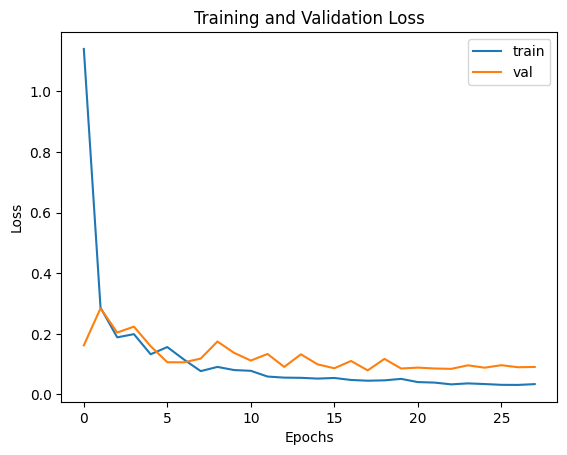

In [113]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

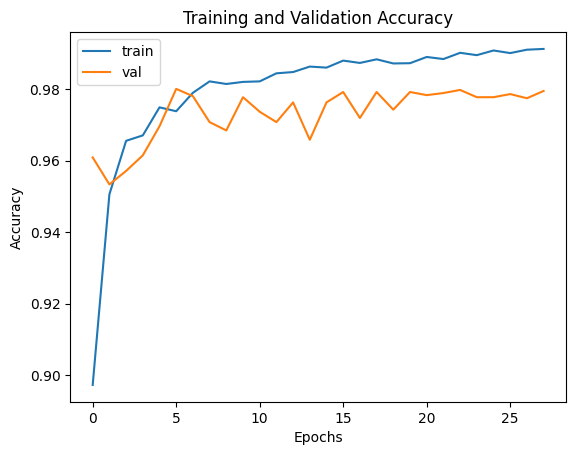

In [114]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [115]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Melakukan prediksi probabilitas
y_pred_prob = model.predict([X_test_features, X_test_text])

# Mengambil kelas prediksi (kelas dengan probabilitas tertinggi)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Menghitung metrik evaluasi untuk setiap kelas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Menyimpan hasil evaluasi ke dictionary
score_dict = {
    'accuracy_score': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
}

# Menampilkan hasil evaluasi
print("Evaluation Scores:")
print(f"Accuracy Score: {score_dict['accuracy_score']:.4f}")
print(f"Precision: {score_dict['precision']:.4f}")
print(f"Recall: {score_dict['recall']:.4f}")
print(f"F1 Score: {score_dict['f1_score']:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
               precision    recall  f1-score   support

       other       0.99      0.99      0.99      3681
    tax_text       0.92      0.97      0.94       138
   tax_value       0.92      0.95      0.93        95
  total_text       0.97      0.96      0.97       198
 total_value       0.89      0.88      0.89       199

    accuracy                           0.98      4311
   macro avg       0.94      0.95      0.94      4311
weighted avg       0.98      0.98      0.98      4311

Confusion Matrix:
 [[3640   11    8    5   17]
 [   4  134    0    0    0]
 [   3    1   90    0    1]
 [   4    0    0  191    3]
 [  24    0    0    0  175]]
Evaluation Scores:
Accuracy Score: 0.9812
Precision: 0.9813
Recall: 0.9812
F1 Score: 0.9812


In [116]:
def predict_class(quad, text, image_size, total_text_quad=None, tax_text_quad=None):
    
    # Memproses fitur geometris
    feature = [
        quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
        quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
        quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
        quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
    ]
    
    # Tambahkan posisi relatif terhadap total_text dan tax_text
    if total_text_quad:
        feature.extend(calculate_relative_position({"quad": quad}, {"quad": total_text_quad}))
    else:
        feature.extend([0, 0])  # Default jika tidak ada total_text
    
    if tax_text_quad:
        feature.extend(calculate_relative_position({"quad": quad}, {"quad": tax_text_quad}))
    else:
        feature.extend([0, 0])  # Default jika tidak ada tax_text
    
    # Ubah menjadi bentuk array 2D
    feature = np.array([feature])

    # Memproses teks
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Prediksi kelas
    predicted_probs = model.predict([feature, text_padded])
    predicted_label = np.argmax(predicted_probs, axis=1)
    predicted_class = label_encoder.inverse_transform(predicted_label)
    return predicted_class[0]


# Contoh input data
example_quad = {
      "x2": 277,
      "y3": 1034,
      "x3": 277,
      "y4": 1034,
      "x1": 187,
      "y1": 998,
      "x4": 187,
      "y2": 998
    }
total_text_quad =  {
      "x2": 277,
      "y3": 1034,
      "x3": 277,
      "y4": 1034,
      "x1": 187,
      "y1": 998,
      "x4": 187,
      "y2": 998
    }
tax_text_quad = {
      "x2": 284,
      "y3": 982,
      "x3": 284,
      "y4": 982,
      "x1": 258,
      "y1": 946,
      "x4": 258,
      "y2": 946
    }
image_size = {'width': 864, 'height': 1296}
example_text = "0000"

# Memanggil fungsi prediksi
predicted = predict_class(example_quad, example_text, image_size,  total_text_quad, tax_text_quad)
print(f"Predicted Class: {predicted}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class: other


In [117]:
# Menampilkan daftar kata (word index) yang dihasilkan oleh Tokenizer
print("Word Index (Daftar Kata):")
print(tokenizer.word_index)

# Menampilkan hasil tokenisasi untuk beberapa teks
print("\nHasil Tokenisasi untuk setiap teks:")
for i, text in enumerate(texts[:5]):  # Ambil 5 teks pertama sebagai contoh
    print(f"Teks asli: {text}")
    print(f"Tokenisasi: {text_sequences[i]}")

Word Index (Daftar Kata):
{'000': 1, '1': 2, 'total': 3, '0': 4, 'cash': 5, '500': 6, '2': 7, '00': 8, 'change': 9, '10': 10, 'subtotal': 11, '20': 12, '3': 13, '50': 14, '100': 15, '5': 16, '22': 17, 'rp': 18, '25': 19, 'sub': 20, '12': 21, 'tax': 22, '4': 23, '30': 24, '6': 25, 'tea': 26, '8': 27, '9': 28, 'pb1': 29, '636': 30, 'item': 31, '17': 32, '1x': 33, '28': 34, '13': 35, 'grand': 36, 'x1': 37, 'cheese': 38, '15': 39, '7': 40, '18': 41, '16': 42, '40': 43, 'kembali': 44, '14': 45, '200': 46, '909': 47, 'nasi': 48, 'items': 49, 'choco': 50, '800': 51, '600': 52, 'discount': 53, 'ice': 54, '60': 55, 'due': 56, '19': 57, '45': 58, 'service': 59, 'tunai': 60, 'x': 61, '24': 62, '29': 63, 'p': 64, '36': 65, '43': 66, '23': 67, '727': 68, '26': 69, '11': 70, 'ayam': 71, '27': 72, 'disc': 73, 's': 74, 'bread': 75, '42': 76, 'medium': 77, 'chicken': 78, '182': 79, '21': 80, '091': 81, '900': 82, 'teh': 83, '70': 84, 'iced': 85, 'bca': 86, '273': 87, 'amount': 88, 'charge': 89, '35': 9

## NLP Character-lavel Embedding

In [118]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import json
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameter
MAX_CHAR_VOCAB = 100  # Batas jumlah karakter unik
MAX_CHAR_SEQUENCE_LENGTH = 50  # Panjang maksimum teks dalam karakter

# Fungsi untuk menghitung posisi relatif
def calculate_relative_position(item, reference_item):
    dx = (item["quad"]["x1"] + item["quad"]["x3"]) / 2 - (reference_item["quad"]["x1"] + reference_item["quad"]["x3"]) / 2
    dy = (item["quad"]["y1"] + item["quad"]["y3"]) / 2 - (reference_item["quad"]["y1"] + reference_item["quad"]["y3"]) / 2
    return [dx, dy]

# Modifikasi fungsi untuk menyertakan posisi relatif
def extract_features_and_labels_with_position(transformed_data):
    features = []
    texts = []  # Menyimpan teks untuk NLP
    labels = []
    
    for row in transformed_data:
        reference_positions = {"total_text": None, "tax_text": None}

        image_size, boxs = row
        
        # Cari posisi total_text dan tax_text sebagai referensi
        for item in boxs:
            if item["label"] in reference_positions:
                reference_positions[item["label"]] = item

        for item in boxs:
            quad = item["quad"]
            text = item["text"]
            label = item["label"]

            # Fitur dasar geometris
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            
            # Tambahkan posisi relatif ke total_text dan tax_text
            if reference_positions["total_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada total_text
            
            if reference_positions["tax_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
            else:
                feature.extend([0, 0])  # Default jika tidak ada tax_text

            features.append(feature)
            texts.append(text)  # Menyimpan teks
            labels.append(label)
    return np.array(features), texts, np.array(labels)

# Ekstrak fitur dan label
features, texts, labels = extract_features_and_labels_with_position(df["transformed"])

# Encode teks ke level karakter
def char_tokenizer(texts):
    vocab = set("".join(texts))  # Membuat karakter unik
    char_to_idx = {char: idx + 1 for idx, char in enumerate(vocab)}  # Mapping karakter ke indeks
    sequences = [[char_to_idx[char] for char in text] for text in texts]  # Tokenisasi
    return sequences, char_to_idx

char_sequences, char_to_idx = char_tokenizer(texts)
char_padded = pad_sequences(char_sequences, maxlen=MAX_CHAR_SEQUENCE_LENGTH)

# Encode label menjadi angka
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Membagi data
X_train_features, X_test_features, X_train_chars, X_test_chars, y_train, y_test = train_test_split(
    features, char_padded, encoded_labels, test_size=0.2, random_state=42
)

# Model TensorFlow
# Input untuk fitur geometris
geo_input = tf.keras.Input(shape=(features.shape[1],), name="geo_input")
geo_dense = tf.keras.layers.Dense(64, activation="relu")(geo_input)

# Input untuk karakter
char_input = tf.keras.Input(shape=(MAX_CHAR_SEQUENCE_LENGTH,), name="char_input")
char_embed = tf.keras.layers.Embedding(input_dim=len(char_to_idx) + 1, output_dim=64)(char_input)
char_lstm = tf.keras.layers.LSTM(64)(char_embed)

# Gabungkan kedua input
combined = tf.keras.layers.concatenate([geo_dense, char_lstm])
combined_dense = tf.keras.layers.Dense(128, activation="relu")(combined)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation="softmax")(combined_dense)

# Buat model
model = tf.keras.Model(inputs=[geo_input, char_input], outputs=output)

# Summary model
model.summary()

# Kompilasi model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Latih model
history = model.fit(
    [X_train_features, X_train_chars], y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[callback]
)

# Evaluasi model
loss, accuracy = model.evaluate([X_test_features, X_test_chars], y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geo_input           │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 50, 64)    │      5,568 │ char_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 64)        │        832 │ geo_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 64)        │     33,024 │ embedding_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 128)       │          0 │ dense_42[0][0],   │
│ (Concatenate)       │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 128)       │     16,512 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 5)         │        645 │ dense_43[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,581 (221.02 KB)

 Trainable params: 56,581 (221.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['geo_input', 'char_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8644 - loss: 1.4905 - val_accuracy: 0.9353 - val_loss: 0.3620
Epoch 2/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9415 - loss: 0.3508 - val_accuracy: 0.9632 - val_loss: 0.1589
Epoch 3/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9578 - loss: 0.2185 - val_accuracy: 0.9693 - val_loss: 0.1470
Epoch 4/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9648 - loss: 0.1723 - val_accuracy: 0.9652 - val_loss: 0.1751
Epoch 5/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9671 - loss: 0.1449 - val_accuracy: 0.9710 - val_loss: 0.1396
Epoch 6/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9739 - loss: 0.1301 - val_accuracy: 0.9754 - val_loss: 0.1109
Epoch 7/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9729 - loss: 0.1324 - val_accuracy: 0.9629 - val_loss: 0.1838
Epoch 8/100
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9767 - loss: 0.0991 - val_accuracy

In [119]:
len(features)

21553

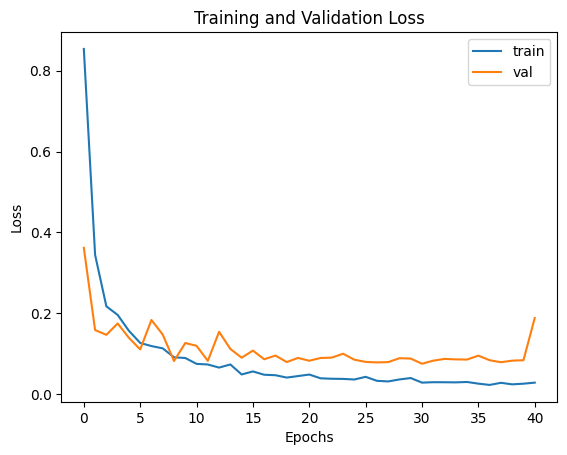

In [120]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

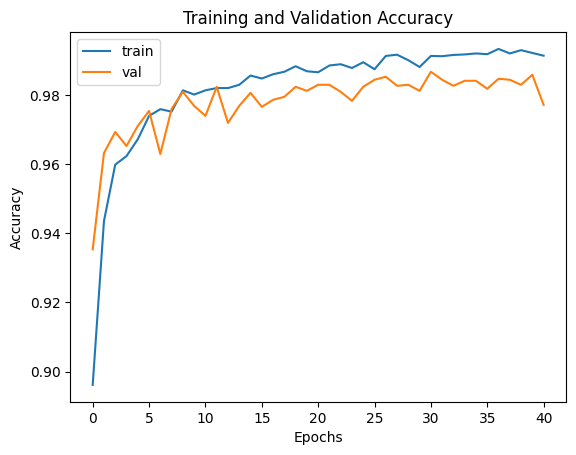

In [121]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [122]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Melakukan prediksi probabilitas
y_pred_prob = model.predict([X_test_features, X_test_chars])

print("Features shape:", X_test_features.shape)
print("Char padded shape:", X_test_chars.shape)

# Mengambil kelas prediksi (kelas dengan probabilitas tertinggi)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Menghitung metrik evaluasi untuk setiap kelas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Menyimpan hasil evaluasi ke dictionary
score_dict = {
    'accuracy_score': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
}

# Menampilkan hasil evaluasi
print("Evaluation Scores:")
print(f"Accuracy Score: {score_dict['accuracy_score']:.4f}")
print(f"Precision: {score_dict['precision']:.4f}")
print(f"Recall: {score_dict['recall']:.4f}")
print(f"F1 Score: {score_dict['f1_score']:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Features shape: (4311, 12)
Char padded shape: (4311, 50)
Classification Report:
               precision    recall  f1-score   support

       other       0.99      0.99      0.99      3681
    tax_text       0.96      0.94      0.95       138
   tax_value       0.93      0.94      0.93        95
  total_text       0.98      0.97      0.98       198
 total_value       0.93      0.94      0.94       199

    accuracy                           0.99      4311
   macro avg       0.96      0.96      0.96      4311
weighted avg       0.99      0.99      0.99      4311

Confusion Matrix:
 [[3650    6    7    4   14]
 [   8  130    0    0    0]
 [   6    0   89    0    0]
 [   5    0    0  193    0]
 [  12    0    0    0  187]]
Evaluation Scores:
Accuracy Score: 0.9856
Precision: 0.9856
Recall: 0.9856
F1 Score: 0.9856


In [123]:
char_to_idx

{'S': 1,
 '*': 2,
 'I': 3,
 '[': 4,
 '%': 5,
 '"': 6,
 'c': 7,
 ']': 8,
 '1': 9,
 'r': 10,
 't': 11,
 'Q': 12,
 'B': 13,
 'Y': 14,
 '4': 15,
 'o': 16,
 '-': 17,
 ',': 18,
 'j': 19,
 'n': 20,
 ')': 21,
 'v': 22,
 'M': 23,
 'N': 24,
 ' ': 25,
 '2': 26,
 '3': 27,
 'h': 28,
 'k': 29,
 'u': 30,
 '6': 31,
 'e': 32,
 '^': 33,
 'W': 34,
 'E': 35,
 'Z': 36,
 'O': 37,
 '.': 38,
 'z': 39,
 '@': 40,
 ';': 41,
 'P': 42,
 '/': 43,
 '9': 44,
 'C': 45,
 '~': 46,
 'K': 47,
 's': 48,
 'L': 49,
 'a': 50,
 'T': 51,
 '0': 52,
 'G': 53,
 'H': 54,
 'R': 55,
 'x': 56,
 'y': 57,
 ':': 58,
 'J': 59,
 '(': 60,
 'U': 61,
 '<': 62,
 'l': 63,
 '&': 64,
 'p': 65,
 'A': 66,
 '8': 67,
 '5': 68,
 'q': 69,
 'b': 70,
 'd': 71,
 'm': 72,
 '>': 73,
 '+': 74,
 'g': 75,
 '7': 76,
 'w': 77,
 'f': 78,
 'V': 79,
 '#': 80,
 'F': 81,
 "'": 82,
 'D': 83,
 '=': 84,
 'i': 85,
 'X': 86}

## Pendekatan 2 Stages Model

### Tahap 1

In [125]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameter
MAX_CHAR_VOCAB = 100
MAX_CHAR_SEQUENCE_LENGTH = 50

# Ekstraksi fitur untuk tahap 1
def extract_features_and_labels_stage1(transformed_data):
    features, texts, labels = [], [], []
    for row in transformed_data:
        image_size, boxs = row
        for item in boxs:
            quad = item["quad"]
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            features.append(feature)
            texts.append(item["text"])
            labels.append(item["label"] if item["label"] in ["total_text", "tax_text", "other"] else "other")
    return np.array(features), texts, np.array(labels)

# Tokenisasi karakter
def char_tokenizer(texts):
    vocab = set("".join(texts))
    char_to_idx = {char: idx + 1 for idx, char in enumerate(vocab)}
    sequences = [[char_to_idx[char] for char in text] for text in texts]
    return sequences, char_to_idx

# Ekstraksi data dan fitur tahap 1
features_stage1, texts_stage1, labels_stage1 = extract_features_and_labels_stage1(df["transformed"])
char_sequences_stage1, char_to_idx = char_tokenizer(texts_stage1)
char_padded_stage1 = pad_sequences(char_sequences_stage1, maxlen=MAX_CHAR_SEQUENCE_LENGTH)
label_encoder_stage1 = LabelEncoder()
encoded_labels_stage1 = label_encoder_stage1.fit_transform(labels_stage1)

# Split data tahap 1
X_train_features_1, X_test_features_1, X_train_chars_1, X_test_chars_1, y_train_1, y_test_1 = train_test_split(
    features_stage1, char_padded_stage1, encoded_labels_stage1, test_size=0.2, random_state=42
)

# Model tahap 1
geo_input_1 = tf.keras.Input(shape=(features_stage1.shape[1],))
char_input_1 = tf.keras.Input(shape=(MAX_CHAR_SEQUENCE_LENGTH,))
geo_dense_1 = tf.keras.layers.Dense(64, activation="relu")(geo_input_1)
char_embed_1 = tf.keras.layers.Embedding(input_dim=len(char_to_idx) + 1, output_dim=64)(char_input_1)
char_lstm_1 = tf.keras.layers.LSTM(64)(char_embed_1)
combined_1 = tf.keras.layers.concatenate([geo_dense_1, char_lstm_1])
combined_dense_1 = tf.keras.layers.Dense(128, activation="relu")(combined_1)
output_1 = tf.keras.layers.Dense(len(label_encoder_stage1.classes_), activation="softmax")(combined_dense_1)

model_stage1 = tf.keras.Model(inputs=[geo_input_1, char_input_1], outputs=output_1)
model_stage1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train model tahap 1
history_stage1 = model_stage1.fit(
    [X_train_features_1, X_train_chars_1], y_train_1,
    validation_split=0.2, epochs=50, batch_size=32, callbacks=[callback]
)

# Evaluasi model tahap 1
loss_1, accuracy_1 = model_stage1.evaluate([X_test_features_1, X_test_chars_1], y_test_1)
print(f"Stage 1 - Test Loss: {loss_1:.4f}")
print(f"Stage 1 - Test Accuracy: {accuracy_1:.4f}")


Epoch 1/50


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_108', 'keras_tensor_109']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9169 - loss: 0.3214 - val_accuracy: 0.9536 - val_loss: 0.1501
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9615 - loss: 0.1167 - val_accuracy: 0.9664 - val_loss: 0.1091
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9698 - loss: 0.0859 - val_accuracy: 0.9693 - val_loss: 0.0993
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9701 - loss: 0.0863 - val_accuracy: 0.9690 - val_loss: 0.0959
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9704 - loss: 0.0773 - val_accuracy: 0.9730 - val_loss: 0.0897
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9765 - loss: 0.0639 - val_accuracy: 0.9701 - val_loss: 0.0945
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9772 - loss: 0.0647 - val_accuracy: 0.9739 - val_loss: 0.0835
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9759 - loss: 0.0666 - val_accuracy: 0.97

In [126]:
len(features_stage1)

21553

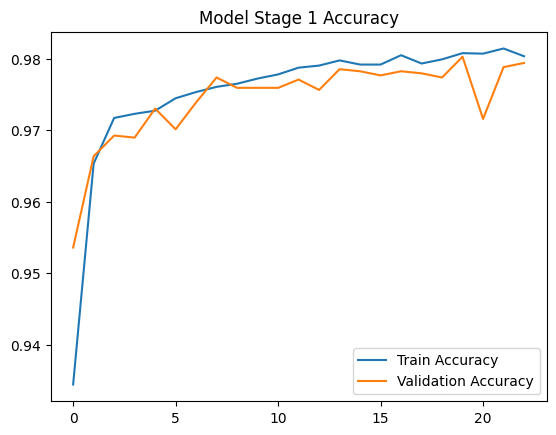

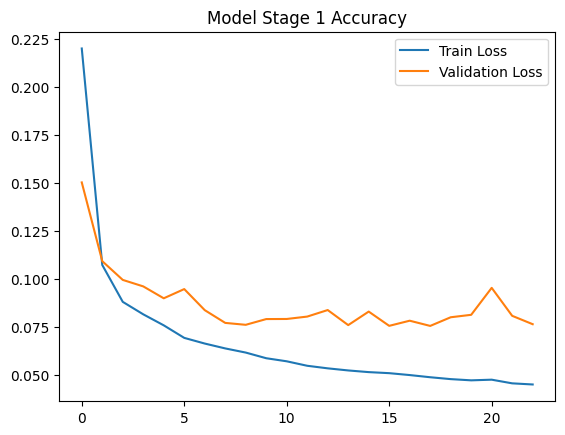

In [127]:
import matplotlib.pyplot as plt

# Stage 1
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Stage 1 Accuracy')
plt.legend()
plt.show()
# Stage 1
plt.plot(history_stage1.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'], label='Validation Loss')
plt.title('Model Stage 1 Accuracy')
plt.legend()
plt.show()


In [128]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Prediksi probabilitas untuk model tahap 1
y_pred_prob_stage1 = model_stage1.predict([X_test_features_1, X_test_chars_1])

# Prediksi kelas
y_pred_stage1 = np.argmax(y_pred_prob_stage1, axis=1)

# Classification Report untuk model tahap 1
print("Classification Report - Model Stage 1:\n", classification_report(
    y_test_1, y_pred_stage1, target_names=label_encoder_stage1.classes_))

# Confusion Matrix untuk model tahap 1
conf_matrix_stage1 = confusion_matrix(y_test_1, y_pred_stage1)
print("Confusion Matrix - Model Stage 1:\n", conf_matrix_stage1)

# Evaluasi metrik
accuracy_stage1 = accuracy_score(y_test_1, y_pred_stage1)
precision_stage1 = precision_score(y_test_1, y_pred_stage1, average='weighted')
recall_stage1 = recall_score(y_test_1, y_pred_stage1, average='weighted')
f1_stage1 = f1_score(y_test_1, y_pred_stage1, average='weighted')

# Menampilkan hasil evaluasi
print(f"Stage 1 - Accuracy: {accuracy_stage1:.4f}")
print(f"Stage 1 - Precision: {precision_stage1:.4f}")
print(f"Stage 1 - Recall: {recall_stage1:.4f}")
print(f"Stage 1 - F1 Score: {f1_stage1:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report - Model Stage 1:
               precision    recall  f1-score   support

       other       0.99      0.99      0.99      3975
    tax_text       0.96      0.89      0.92       138
  total_text       0.79      0.91      0.85       198

    accuracy                           0.98      4311
   macro avg       0.91      0.93      0.92      4311
weighted avg       0.98      0.98      0.98      4311

Confusion Matrix - Model Stage 1:
 [[3922    5   48]
 [  15  123    0]
 [  17    0  181]]
Stage 1 - Accuracy: 0.9803
Stage 1 - Precision: 0.9817
Stage 1 - Recall: 0.9803
Stage 1 - F1 Score: 0.9807


### Tahap 2

In [129]:
# Fungsi menghitung posisi relatif
def calculate_relative_position(item, reference_item):
    dx = (item["quad"]["x1"] + item["quad"]["x3"]) / 2 - (reference_item["quad"]["x1"] + reference_item["quad"]["x3"]) / 2
    dy = (item["quad"]["y1"] + item["quad"]["y3"]) / 2 - (reference_item["quad"]["y1"] + reference_item["quad"]["y3"]) / 2
    return [dx, dy]

# Ekstraksi fitur untuk tahap 2
def extract_features_and_labels_stage2(transformed_data, predictions_stage1):
    features, texts, labels = [], [], []
    prediction_index1 = 0
    prediction_index2 = 0

    for row in transformed_data:
        image_size, boxs = row
        reference_positions = {"total_text": None, "tax_text": None}
        for item in boxs:
            if predictions_stage1[prediction_index1] == "total_text":
                reference_positions["total_text"] = item
            elif predictions_stage1[prediction_index1] == "tax_text":
                reference_positions["tax_text"] = item
            prediction_index1 += 1

        for item in boxs:
            quad = item["quad"]
            feature = [
                quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
                quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
                quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
                quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
            ]
            if reference_positions["total_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
            else:
                feature.extend([0, 0])
            if reference_positions["tax_text"]:
                feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
            else:
                feature.extend([0, 0])

            # Masukkan semua label ke dalam tahap 2
            features.append(feature)
            texts.append(item["text"])
            labels.append(item['label'])
            # if item["label"] in ["total_value", "tax_value", "total_text", "tax_text"]:
            #     labels.append(item["label"])
            # else:
            #     labels.append("other")
            prediction_index2 += 1
    return np.array(features), texts, np.array(labels)


# Ekstraksi data dan fitur tahap 1
features_stage1, texts_stage1, labels_stage1 = extract_features_and_labels_stage1(df["transformed"])
char_sequences_stage1, char_to_idx = char_tokenizer(texts_stage1)
char_padded_stage1 = pad_sequences(char_sequences_stage1, maxlen=MAX_CHAR_SEQUENCE_LENGTH)

# Prediksi untuk Tahap 2
predictions_stage1 = np.argmax(model_stage1.predict([features_stage1, char_padded_stage1]), axis=1)
predictions_stage1_labels = label_encoder_stage1.inverse_transform(predictions_stage1)

# Pastikan test_indices cocok dengan DataFrame
df_copy = df['transformed']


# Ekstraksi data untuk Tahap 2
features_stage2, texts_stage2, labels_stage2 = extract_features_and_labels_stage2(
    df_copy, predictions_stage1_labels
)

# Encode label untuk Tahap 2
label_encoder_stage2 = LabelEncoder()
encoded_labels_stage2 = label_encoder_stage2.fit_transform(labels_stage2)

# Tokenisasi dan padding untuk teks Tahap 2
char_sequences_stage2 = [[char_to_idx[char] for char in text if char in char_to_idx] for text in texts_stage2]
char_padded_stage2 = pad_sequences(char_sequences_stage2, maxlen=MAX_CHAR_SEQUENCE_LENGTH)

# Split data untuk Tahap 2
X_train_features_2, X_test_features_2, X_train_chars_2, X_test_chars_2, y_train_2, y_test_2 = train_test_split(
    features_stage2, char_padded_stage2, encoded_labels_stage2, test_size=0.2, random_state=42
)

# Model Tahap 2
geo_input_2 = tf.keras.Input(shape=(features_stage2.shape[1],))
geo_dense_2 = tf.keras.layers.Dense(64, activation="relu")(geo_input_2)

char_input_2 = tf.keras.Input(shape=(MAX_CHAR_SEQUENCE_LENGTH,))
char_embed_2 = tf.keras.layers.Embedding(input_dim=len(char_to_idx) + 1, output_dim=64)(char_input_2)
char_lstm_2 = tf.keras.layers.LSTM(64)(char_embed_2)

combined_2 = tf.keras.layers.concatenate([geo_dense_2, char_lstm_2])
combined_dense_2 = tf.keras.layers.Dense(128, activation="relu")(combined_2)
output_2 = tf.keras.layers.Dense(len(label_encoder_stage2.classes_), activation="softmax")(combined_dense_2)

model_stage2 = tf.keras.Model(inputs=[geo_input_2, char_input_2], outputs=output_2)

# Kompilasi Model Tahap 2
model_stage2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Pelatihan Model Tahap 2
callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_stage2 = model_stage2.fit(
    [X_train_features_2, X_train_chars_2], y_train_2,
    validation_split=0.2, epochs=50, batch_size=32, callbacks=[callback]
)

# Evaluasi Model Tahap 2
loss_2, accuracy_2 = model_stage2.evaluate([X_test_features_2, X_test_chars_2], y_test_2)
print(f"Stage 2 - Test Loss: {loss_2:.4f}")
print(f"Stage 2 - Test Accuracy: {accuracy_2:.4f}")


674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
Epoch 1/50


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_116', 'keras_tensor_118']. Received: the structure of inputs=('*', '*')
  warnings.warn(


432/432 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8151 - loss: 3.7324 - val_accuracy: 0.9127 - val_loss: 0.5177
Epoch 2/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9156 - loss: 0.4339 - val_accuracy: 0.9119 - val_loss: 0.7187
Epoch 3/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9362 - loss: 0.3536 - val_accuracy: 0.9440 - val_loss: 0.2979
Epoch 4/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9400 - loss: 0.2945 - val_accuracy: 0.9545 - val_loss: 0.1837
Epoch 5/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9494 - loss: 0.2448 - val_accuracy: 0.9600 - val_loss: 0.1598
Epoch 6/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9507 - loss: 0.2250 - val_accuracy: 0.9609 - val_loss: 0.1865
Epoch 7/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9610 - loss: 0.1527 - val_accuracy: 0.9582 - val_loss: 0.1715
Epoch 8/50
432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9662 - loss: 0.1321 - val_accuracy: 0.952

In [130]:
len(labels_stage2)

21553

In [131]:
len(predictions_stage1_labels)

21553

In [132]:
len(features_stage2)

21553

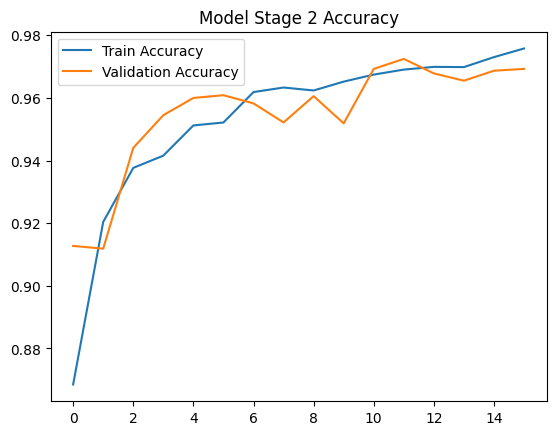

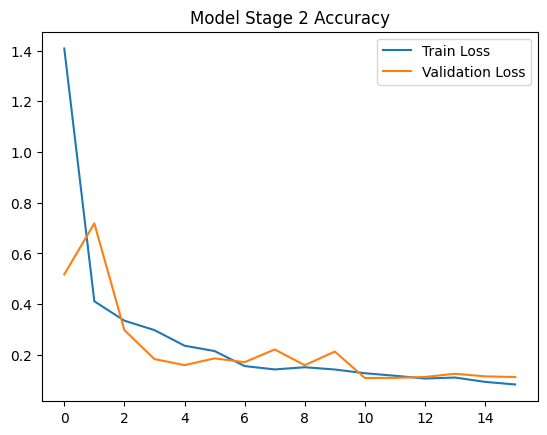

In [133]:

# Stage 2
plt.plot(history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Stage 2 Accuracy')
plt.legend()
plt.show()

# Stage 2
plt.plot(history_stage2.history['loss'], label='Train Loss')
plt.plot(history_stage2.history['val_loss'], label='Validation Loss')
plt.title('Model Stage 2 Accuracy')
plt.legend()
plt.show()


In [135]:
# Prediksi probabilitas untuk model tahap 2
y_pred_prob_stage2 = model_stage2.predict([X_test_features_2, X_test_chars_2])

# Prediksi kelas
y_pred_stage2 = np.argmax(y_pred_prob_stage2, axis=1)

# Classification Report untuk model tahap 2
print("Classification Report - Model Stage 2:\n", classification_report(
    y_test_2, y_pred_stage2, target_names=label_encoder_stage2.classes_))

# Confusion Matrix untuk model tahap 2
conf_matrix_stage2 = confusion_matrix(y_test_2, y_pred_stage2)
print("Confusion Matrix - Model Stage 2:\n", conf_matrix_stage2)

# Evaluasi metrik
accuracy_stage2 = accuracy_score(y_test_2, y_pred_stage2)
precision_stage2 = precision_score(y_test_2, y_pred_stage2, average='weighted')
recall_stage2 = recall_score(y_test_2, y_pred_stage2, average='weighted')
f1_stage2 = f1_score(y_test_2, y_pred_stage2, average='weighted')

# Menampilkan hasil evaluasi
print(f"Stage 2 - Accuracy: {accuracy_stage2:.4f}")
print(f"Stage 2 - Precision: {precision_stage2:.4f}")
print(f"Stage 2 - Recall: {recall_stage2:.4f}")
print(f"Stage 2 - F1 Score: {f1_stage2:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report - Model Stage 2:
               precision    recall  f1-score   support

       other       0.98      0.98      0.98      3681
    tax_text       0.97      0.89      0.93       138
   tax_value       0.92      0.82      0.87        95
  total_text       0.81      0.93      0.87       198
 total_value       0.86      0.81      0.84       199

    accuracy                           0.96      4311
   macro avg       0.91      0.89      0.90      4311
weighted avg       0.96      0.96      0.96      4311

Confusion Matrix - Model Stage 2:
 [[3608    4    6   38   25]
 [  14  123    0    1    0]
 [  13    0   78    3    1]
 [  14    0    0  184    0]
 [  36    0    1    0  162]]
Stage 2 - Accuracy: 0.9638
Stage 2 - Precision: 0.9644
Stage 2 - Recall: 0.9638
Stage 2 - F1 Score: 0.9638


In [137]:
def predict_stage1_and_stage2(input_data, model_stage1, model_stage2, char_to_idx, label_encoder_stage1, label_encoder_stage2, image_size):
    # Preprocess input data
    features = []
    texts = []
    for item in input_data:
        quad = item['quad']
        feature = [
            quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
            quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
            quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
            quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
        ]
        features.append(feature)
        texts.append(item['text'])

    features = np.array(features)
    char_sequences = [[char_to_idx[char] for char in text if char in char_to_idx] for text in texts]
    char_padded = pad_sequences(char_sequences, maxlen=MAX_CHAR_SEQUENCE_LENGTH)

    # Predict stage 1
    predictions_stage1 = np.argmax(model_stage1.predict([features, char_padded]), axis=1)
    predictions_stage1_labels = label_encoder_stage1.inverse_transform(predictions_stage1)

    # Prepare data for stage 2
    reference_positions = {"total_text": None, "tax_text": None}
    for i, item in enumerate(input_data):
        if predictions_stage1_labels[i] == "total_text":
            reference_positions["total_text"] = item
        elif predictions_stage1_labels[i] == "tax_text":
            reference_positions["tax_text"] = item

    features_stage2 = []
    for item in input_data:
        quad = item['quad']
        feature = [
            quad["x1"] / image_size['width'], quad["y1"] / image_size['height'], 
            quad["x2"] / image_size['width'], quad["y2"] / image_size['height'], 
            quad["x3"] / image_size['width'], quad["y3"] / image_size['height'], 
            quad["x4"] / image_size['width'], quad["y4"] / image_size['height']
        ]
        if reference_positions["total_text"]:
            feature.extend(calculate_relative_position(item, reference_positions["total_text"]))
        else:
            feature.extend([0, 0])
        if reference_positions["tax_text"]:
            feature.extend(calculate_relative_position(item, reference_positions["tax_text"]))
        else:
            feature.extend([0, 0])
        features_stage2.append(feature)

    features_stage2 = np.array(features_stage2)

    # Predict stage 2
    predictions_stage2 = np.argmax(model_stage2.predict([features_stage2, char_padded]), axis=1)
    predictions_stage2_labels = label_encoder_stage2.inverse_transform(predictions_stage2)

    # Combine results
    results = []
    for i, item in enumerate(input_data):
        results.append({
            "text": item["text"],
            "quad": item["quad"],
            "stage1_label": predictions_stage1_labels[i],
            "stage2_label": predictions_stage2_labels[i],
        })
    return results



# Data input tanpa label
input_data = [
  {'quad': {'x2': 172, 'y3': 836, 'x3': 172, 'y4': 836, 'x1': 96, 'y1': 800, 'x4': 96, 'y2': 800}, 'text': 'BASO'},
  {'quad': {'x2': 272, 'y3': 834, 'x3': 272, 'y4': 834, 'x1': 180, 'y1': 798, 'x4': 180, 'y2': 798}, 'text': 'BIHUN'},
  {'quad': {'x2': 444, 'y3': 830, 'x3': 444, 'y4': 830, 'x1': 424, 'y1': 796, 'x4': 424, 'y2': 796}, 'text': '1'},
  {'quad': {'x2': 558, 'y3': 830, 'x3': 558, 'y4': 830, 'x1': 454, 'y1': 794, 'x4': 454, 'y2': 794}, 'text': '43.636'},
  {'quad': {'x2': 734, 'y3': 830, 'x3': 734, 'y4': 830, 'x1': 630, 'y1': 794, 'x4': 630, 'y2': 794}, 'text': '43.636'},
  {'quad': {'x2': 184, 'y3': 886, 'x3': 184, 'y4': 886, 'x1': 94, 'y1': 850, 'x4': 94, 'y2': 850}, 'text': 'TOTAL'},
  {'quad': {'x2': 742, 'y3': 878, 'x3': 742, 'y4': 878, 'x1': 636, 'y1': 842, 'x4': 636, 'y2': 842}, 'text': '43.636'},
  {'quad': {'x2': 148, 'y3': 984, 'x3': 148, 'y4': 984, 'x1': 90, 'y1': 948, 'x4': 90, 'y2': 948}, 'text': 'TAX'},
  {'quad': {'x2': 249, 'y3': 984, 'x3': 249, 'y4': 984, 'x1': 157, 'y1': 948, 'x4': 157, 'y2': 948}, 'text': '10.00'},
  {'quad': {'x2': 284, 'y3': 982, 'x3': 284, 'y4': 982, 'x1': 258, 'y1': 946, 'x4': 258, 'y2': 946}, 'text': '%'},
  {'quad': {'x2': 747, 'y3': 976, 'x3': 747, 'y4': 976, 'x1': 655, 'y1': 940, 'x4': 655, 'y2': 940}, 'text': '4.364'},
  {'quad': {'x2': 177, 'y3': 1034, 'x3': 177, 'y4': 1034, 'x1': 83, 'y1': 998, 'x4': 83, 'y2': 998}, 'text': 'GRAND'},
  {'quad': {'x2': 277, 'y3': 1034, 'x3': 277, 'y4': 1034, 'x1': 187, 'y1': 998, 'x4': 187, 'y2': 998}, 'text': 'TOTAL'},
  {'quad': {'x2': 745, 'y3': 1023, 'x3': 746, 'y4': 1027, 'x1': 637, 'y1': 989, 'x4': 638, 'y2': 986}, 'text': '48.000'},
  {'quad': {'x2': 178, 'y3': 1086, 'x3': 178, 'y4': 1086, 'x1': 86, 'y1': 1048, 'x4': 86, 'y2': 1048}, 'text': 'TUNAI'},
  {'quad': {'x2': 751, 'y3': 1071, 'x3': 752, 'y4': 1075, 'x1': 643, 'y1': 1040, 'x4': 644, 'y2': 1036}, 'text': '50.000'},
  {'quad': {'x2': 208, 'y3': 1136, 'x3': 207, 'y4': 1133, 'x1': 82, 'y1': 1096, 'x4': 81, 'y2': 1099}, 'text': 'KEMBALI'},
  {'quad': {'x2': 747, 'y3': 1121, 'x3': 748, 'y4': 1124, 'x1': 657, 'y1': 1087, 'x4': 658, 'y2': 1084}, 'text': '2.000'}
]


# Dimensi gambar
image_size = {'width': 864, 'height': 1296}

# Prediksi
predicted_results = predict_stage1_and_stage2(
    input_data=input_data,
    model_stage1=model_stage1,
    model_stage2=model_stage2,
    char_to_idx=char_to_idx,
    label_encoder_stage1=label_encoder_stage1,
    label_encoder_stage2=label_encoder_stage2,
    image_size=image_size
)

# Cetak hasil
for result in predicted_results:
    # print(f"Text: {result['text']}, Stage 1 Label: {result['stage1_label']}, Stage 2 Label: {result['stage2_label']}")
    print(f"Text: {result['text']}, Label: {result['stage2_label']}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Text: BASO, Label: other
Text: BIHUN, Label: other
Text: 1, Label: other
Text: 43.636, Label: other
Text: 43.636, Label: other
Text: TOTAL, Label: other
Text: 43.636, Label: other
Text: TAX, Label: tax_text
Text: 10.00, Label: tax_text
Text: %, Label: tax_text
Text: 4.364, Label: tax_value
Text: GRAND, Label: total_text
Text: TOTAL, Label: total_text
Text: 48.000, Label: total_value
Text: TUNAI, Label: other
Text: 50.000, Label: other
Text: KEMBALI, Label: other
Text: 2.000, Label: other
